In [1]:
from IPython.core.interactiveshell import InteractiveShell
import warnings 
import pickle
import numpy as np
InteractiveShell.ast_node_interactive = "all"
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm
import pandas as pd
import torch                                      # root package
from torch.utils.data import Dataset, DataLoader  # data 
import torch.nn as nn                             # neural networks
import torch.nn.functional as F                   # layers, activations and more
import matplotlib.pyplot as plt
import torchaudio                                 # audio processing
import torchvision
import torch.optim as optim
print(torch.cuda.is_available())

True


In [2]:
def get_dataset(name):
    df = pd.DataFrame.from_dict(pickle.load(open(f"./data/{name}.p", "rb")).items())
    df.rename(columns={0:"path", 1:"class"}, inplace=True)
    return df
def get_df(name):
    return pickle.load(open(f"./data/{name}.p", "rb"))

In [3]:
def splitting_ds():
    df = get_dataset("total")
    train, validate, test = np.split(df.sample(frac=1, random_state=42), [int(.6*len(df)), int(.8*len(df))])
    dfs = {"train":train,"validate":validate, "test":test}
    for name,df_split in dfs.items():
        print("size:", df_split.shape)
        print(df_split.columns)
        pickle.dump(df_split, open(f"./data/{name}.p", "wb"))
        df_split.head()

# Stats and plotting function

In [4]:
def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("*"*10)
        print("Source:", src)
        print("*"*10)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")


def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].set_xlabel("Time [s]")
        axes[c].set_ylabel("Amplitude")
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
        
    figure.suptitle(title)
    plt.show(block=False)




def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()
    num_channels, _ = waveform.shape
    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate, sides="onesided")
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        axes[c].set_xlabel("Time [s]")
        axes[c].set_ylabel("Frequency [Hz]")
    figure.suptitle(title)
    plt.show(block=False)

# Development 

metadata:  AudioMetaData(sample_rate=32000, num_frames=4654336, num_channels=1, bits_per_sample=0, encoding=MP3)
 - Max:      0.560
 - Min:     -0.583
 - Mean:     0.000
 - Std Dev:  0.033


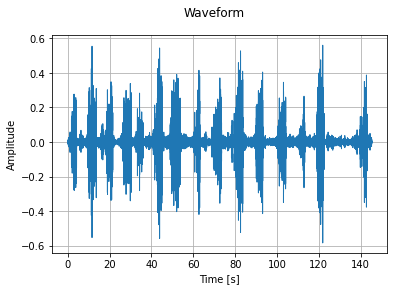

KeyboardInterrupt: 

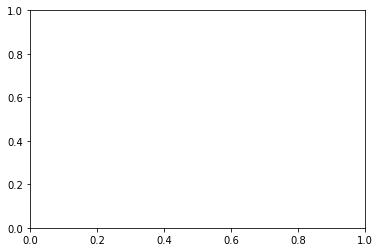

In [16]:
SAMPLE_MP3_PATH = ("/home/akinwilson/Projects/bird-sound-classifier/data/birds/Phylloscopuscollybita/Poland"
"/Phylloscopuscollybita325319.mp3")
metadata = torchaudio.info(SAMPLE_MP3_PATH)
print("metadata: ", metadata)
def _get_sample(path, resample=None):
    effects = [["remix", "1"]]
    if resample:
        effects.extend(
            [
                ["lowpass", f"{resample // 2}"],
                ["rate", f"{resample}"],
            ]
        )
    return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

def get_sample(SAMPLE_WAV_PATH, resample=None):
    return _get_sample(SAMPLE_WAV_PATH, resample=resample)
SAMPLE_RATE = 32000
waveform, sample_rate = get_sample(SAMPLE_MP3_PATH, resample=SAMPLE_RATE)
print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)

# Dataset and Dataloader definition

In [5]:
extract_spectrogram = torchaudio.transforms.Spectrogram()
normalise_img = torchvision.transforms.Normalize((0.485,), (0.225,))
transformations = torch.nn.Sequential(extract_spectrogram,
                                      normalise_img)


class AudioDataset(Dataset):
    def __init__(self,ds_name, input_transform=None):
        sample_size = 10 if ds_name == "validate" else 200
        self.files = get_df(f"{ds_name}").sample(n=sample_size)  # .samepl[:20]
        self.cls2id = {name:idx for idx,name in enumerate(list(self.files['class'].unique()))}
        self.input_transform = input_transform
        self.NEW_SAMPLE_RATE = 16000



    def __len__(self):
        return len(self.files)



    def __getitem__(self, idx):
        data_path = self.files.iloc[idx]['path']
        data_label = self.files.iloc[idx]['class']
        audio_data, OLD_SAMPLE_RATE = torchaudio.load(data_path, normalize=True)
        audio_data = torch.unsqueeze(audio_data[0,:OLD_SAMPLE_RATE * 10], 0)
        apply_resampling  = torchaudio.transforms.Resample(orig_freq= OLD_SAMPLE_RATE ,
                                                           new_freq= self.NEW_SAMPLE_RATE,
                                                           resampling_method= 'sinc_interpolation',
                                                           lowpass_filter_width = 6,
                                                           rolloff = 0.99)
        audio_data = apply_resampling(audio_data)
        audio_data = torch.unsqueeze(audio_data[0,:self.NEW_SAMPLE_RATE*10], 0)

        while audio_data.shape[-1] < self.NEW_SAMPLE_RATE*10:
            audio_data = torch.concat((audio_data,audio_data), dim=1)
            audio_data = torch.unsqueeze(audio_data[0,:self.NEW_SAMPLE_RATE * 10], 0)
            
        if self.input_transform:
            audio_input = self.input_transform(audio_data)
        
        target_label = torch.tensor(self.cls2id[data_label], dtype=torch.int16).type(torch.LongTensor)        
        return audio_input, target_label

In [7]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,  out_channels=6,  kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=6,  out_channels=16, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=6,  kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=6,  out_channels=1,  kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.drop_out = torch.nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(480, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.drop_out(x)
        x = F.relu(self.fc2(x))
        x = self.drop_out(x)
        x = F.softmax(self.fc3(x))
        return x


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device used for training: {device}")



net = Net(num_classes=19)
net.eval()
net.to(device)
criterion = nn.CrossEntropyLoss( )
optimizer = optim.Adam(net.parameters(), lr=0.001)

Device used for training: cuda:0


In [9]:
ds_train = AudioDataset(ds_name="train", input_transform=transformations)
ds_val = AudioDataset(ds_name="validate", input_transform=transformations)

train_dataloader = DataLoader(ds_train, num_workers=4, batch_size=64, shuffle=True)
val_dataloader = DataLoader(ds_val, num_workers=4, batch_size=128, shuffle=True)

MAX_EPOCHS = 100
train_loss_hist = []
val_loss_hist = []
accuracy_hist = []

for epoch in tqdm(range(MAX_EPOCHS)):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print("loss: ", loss.item())
    print("*"*40)
    print(f'Epoch:{epoch + 1}\nAvg loss: {running_loss /len(train_dataloader)}')
    print("*"*40)
    train_loss_hist.append(loss.item())
    print("Entering validation...")
    net.eval()
    with torch.no_grad():
        for data in val_dataloader:
            inputs, true_labels = data
            true = true_labels.numpy() 
            inputs = inputs.to(device)
            pred_labels = net(inputs)
            predicted = [(pred_label == torch.max(pred_label)).nonzero().flatten().cpu().numpy()[0]
                         for pred_label
                         in pred_labels]

            result = [x==y for (x,y) in zip(true,predicted)]
            acc = sum(result)/len(result)
            print(f"Accuracy: {acc*100}%")
            accuracy_hist.append(acc)
    print("Exiting validation...")
    net.train()
    running_loss = 0.0

  0%|          | 0/100 [00:00<?, ?it/s]

loss:  2.9384236335754395
loss:  2.925779104232788
loss:  2.9486618041992188
loss:  2.8560311794281006
****************************************
Epoch:1
Avg loss: 2.9172239303588867
****************************************
Entering validation...
Accuracy: 30.0%
loss:  2.8372609615325928
loss:  2.9429049491882324
loss:  2.913405418395996
loss:  2.8372995853424072
****************************************
Epoch:2
Avg loss: 2.882717728614807
****************************************
Entering validation...
Accuracy: 60.0%
loss:  2.9095237255096436
loss:  2.8873188495635986
loss:  2.822355270385742
loss:  2.839362382888794
****************************************
Epoch:3
Avg loss: 2.8646400570869446
****************************************
Entering validation...
Accuracy: 60.0%
loss:  2.8134446144104004
loss:  2.882641553878784
loss:  2.8618972301483154
loss:  2.800187349319458
****************************************
Epoch:4
Avg loss: 2.8395426869392395
***************************************

KeyboardInterrupt: 

# Evaluation

In [ ]:
correct,total = 0,0
ds_test =  AudioDataset(ds_name="test", input_transform=transformations)
test_loader = DataLoader(ds_test, batch_size=64, shuffle=True)
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on {len(test_loader)} audio examples: {100 * correct // total} %')